In [1]:
from SimplifiedAstrocyteModel import *
from SimplifiedAstrocyteParameters import *
from SimplifiedAstrocyteSupport import *

from numpy import linalg
from scipy.optimize import fsolve

from matplotlib.lines import Line2D

### Figure S4: Simplified model response to glutamate and dopamine

In [13]:
### Simulation Parameters ###
dt = 0.001
sample_rate = 1
t_total = 100
compartment_to_monitor = np.array([1,2,3,4,5,6,7,8,9], dtype = int)


### Astrocyte Morphology ###
# Import astrocyte morphology model
points = read_from_swc('../../Morphology/Linear_9comparts_corr.txt')
morp_params = calculate_morphological_parameters(points)
connection_matrix = build_connection_matrix(points)

# Correct diffusion factor for compartment dimensions
connection_matrix[0, 1] = 0.183e-4
connection_matrix[1, 0] = 0.049

# Get astrocyte morphology parameters
n_comparts = morp_params.shape[0]
A = morp_params[:,3]
Vol = morp_params[:,5]
r_ER = morp_params[:,6]


### Model Parameters ###
model_parameters = define_parameters()
model_parameters['i_rest']  = float(bissec_method(null_IP3, a = 0, b = 1, p = model_parameters))
    
Ca_ERalpha = np.zeros(n_comparts)
for i_c in range(n_comparts):
    Ca_ERalpha[i_c] = bissec_method(null_caer, a = 0, b = 5, tol = 1e-10, p = model_parameters, A = A[i_c], 
                                    Vol = Vol[i_c], r_ER = r_ER[i_c])
        
p = create_numba_dictionary(model_parameters)

    
### Stimuli ###    
# Glutamate Stimulation
stim_glu_types = tuple(['poisson'])
stim_glu_t_init = tuple([0])
stim_glu_t_end = tuple([100])
stim_glu_Hz = tuple([5])
stim_glu_comparts = ([7,8,9],)
    
# Dopaminergic Stimulation
stim_DA_types = tuple(['none'])
stim_DA_t_init= tuple([0])
stim_DA_t_end = tuple([100])
stim_DA_Hz = tuple([10])
stim_DA_comparts = ([1,2,3,4,5,6,7,8,9],)


### Run simulation ###
Ca_iout = solve_model_equations(dt, sample_rate, compartment_to_monitor, t_total, n_comparts, connection_matrix, p, A, Vol, 
                                r_ER, stim_glu_types, stim_glu_t_init, stim_glu_t_end, stim_glu_Hz, stim_glu_comparts, 
                                stim_DA_types, stim_DA_t_init, stim_DA_t_end, stim_DA_Hz, stim_DA_comparts, Ca_ERalpha)


In [1]:
fig, ax = plt.subplots(1, 1, figsize = (2.5, 2.5))
plt.subplots_adjust(wspace = 0.6)


# First Graph
t = np.linspace(0, t_total, Ca_iout.shape[1])

colors = ['b', 'g', 'g', 'g', 'r', 'r', 'orange', 'orange', 'orange']
ls = ['-', '-', '--', ':', '-', '--', '-', '--', ':']

for i_ca, ca_i in enumerate(Ca_iout): ax.plot(t, Ca_iout[i_ca], label = i_ca + 1, ls = ls[i_ca], color = colors[i_ca])

    
    
# Axis parameters
ax.set_ylim(0, 1.5)
ax.set_ylabel(r'$c$', fontsize = 10)
 
ax.set_xlim(0, t_total)
ax.set_xlabel('t (s)', fontsize = 10)
    
ax.tick_params(axis = 'both', which = 'both', labelsize = 8)

# Remove spines
for spine in ['top', 'right']: ax.spines[spine].set_visible(False)
        
fig.legend(ncols = 9, loc = 'upper center', fontsize = 8, facecolor ='white', framealpha = 1)

NameError: name 'plt' is not defined

# Dynamical System Analysis

## Support Functions

In [2]:
def null_dCa_idt(i, c, p, A, Vol, r_ER, Ca_ERalpha):
                
    I_NCX     = f_I_NCX(p['alpha_NCX'], p['beta_NCX'], c)
    I_IP3R    = f_I_IP3R (p['F'], A, Vol, r_ER, p['r_C'], i, p['d_1'], Ca_ERalpha, c, p['d_5'], p['h'])
    I_SERCA   = f_I_SERCA(p['F'], A, Vol, p['v_ER'], c, p['K_ER'])
    I_CERleak = f_I_CERleak(p['F'], A, Vol, r_ER, p['r_L'], Ca_ERalpha, c)

    return A / (Vol * p['F']) * I_NCX + A * np.sqrt(r_ER) / (Vol * p['F']) * (I_IP3R - I_SERCA + I_CERleak)

def null_dIP3dt(i, c, Glu_o, DA_o, p):
        
    prod_PLCb_glu = f_prod_PLCb_glu(p['v_beta'], Glu_o, p['alpha'], p['K_R'], p['K_p'], c, p['K_pi'])
    prod_PLCb_DA  = f_prod_PLCb_DA(p['v_DA'], DA_o, p['beta'], p['K_DA'], p['K_p'], c, p['K_pi'])
    prod_PLCd     = f_prod_PLCd(p['v_delta'], i, p['kappa_delta'], c, p['K_PLCdelta'])
    degr_IP3_3K   = f_degr_IP3_3K(p['v_3K'], c, p['K_D'], i, p['K_3'])
    degr_IP_5P    = f_degr_IP_5P(p['r_5P'], i)
    
    return prod_PLCb_glu + prod_PLCd + prod_PLCb_DA - degr_IP3_3K - degr_IP_5P

def analytic_nullCai(c, p, A, Vol, r_ER, Ca_ERalpha):
    
    CaER = Ca_ERalpha*calculate_caer(r_ER, c)
            
    I_NCX     = np.sqrt(r_ER)/r_ER*f_I_NCX(p['alpha_NCX'], p['beta_NCX'], c)
    I_SERCA   = f_I_SERCA(p['F'], A, Vol, p['v_ER'], c, p['K_ER'])
    I_CERleak = f_I_CERleak(p['F'], A, Vol, r_ER, p['r_L'], Ca_ERalpha, c)
    
    h = 0.8**3
    
    gama = A/(Vol*p['F'])*(I_SERCA-I_CERleak-I_NCX)/(((c/(c+p['d_5']))**3)*p['r_C']*h*(CaER - c))
    gama = np.cbrt(gama)
    
    return gama*p['d_1']/(1 - gama)

def null_point(var, p, A, Vol, r_ER, Ca_ERalpha, Glu_o, DA_o):
        
    I_NCX     = f_I_NCX(p['alpha_NCX'], p['beta_NCX'] ,var[1])
    I_IP3R    = f_I_IP3R (p['F'], A, Vol, r_ER, p['r_C'], var[0], p['d_1'], Ca_ERalpha, var[1], p['d_5'], p['h'])
    I_SERCA   = f_I_SERCA(p['F'], A, Vol, p['v_ER'], var[1], p['K_ER'])
    I_CERleak = f_I_CERleak(p['F'], A, Vol, r_ER, p['r_L'], Ca_ERalpha, var[1])
    
    dCa_idt = A / (Vol * p['F']) * I_NCX + A * np.sqrt(r_ER) / (Vol * p['F']) * (I_IP3R - I_SERCA + I_CERleak)
    
    prod_PLCb_glu = f_prod_PLCb_glu(p['v_beta'], Glu_o, p['alpha'], p['K_R'], p['K_p'], var[1], p['K_pi'])
    prod_PLCd     = f_prod_PLCb_DA(p['v_DA'], DA_o, p['beta'], p['K_DA'], p['K_p'], var[1], p['K_pi'])
    prod_PLCb_DA  = f_prod_PLCd(p['v_delta'], var[0], p['kappa_delta'], var[1], p['K_PLCdelta'])
    degr_IP3_3K   = f_degr_IP3_3K(p['v_3K'], var[1], p['K_D'], var[0], p['K_3'])
    degr_IP_5P    = f_degr_IP_5P(p['r_5P'], var[0])
    
    dIP3_dt = prod_PLCb_glu + prod_PLCd + prod_PLCb_DA - degr_IP3_3K - degr_IP_5P
    
    return np.array([dCa_idt, dIP3_dt])

# Jacobian

def system_jacobian(c, i, Glu, DA, p, A, Vol, r_ER, Ca_ERalpha):
    
    alpha_CaER = Ca_ERalpha*calc_alpha_CaER(r_ER)
    beta_CaER = Ca_ERalpha*calc_beta_CaER(r_ER)
    AVolF = A / (Vol * p['F'])
    
    h = 0.8**3
    
    ## dCa_dCa
    p1 = -AVolF * p['alpha_NCX']
    p2 = (3*p['r_C']*h*(c/(c+p['d_5']))**2*(p['d_5']/(c+p['d_5'])**2)*
          (i/(i+p['d_1']))**3*(beta_CaER - (1+alpha_CaER)*c))
    p3 = - p['r_C']*h*(i/(i+p['d_1']))**3*(c/(c+p['d_5']))**3*(1+alpha_CaER)
    p4 = -p['r_L']*(1+alpha_CaER)
    p5 = - p['v_ER']*(2*c*p['K_ER']**2/(c**2 + p['K_ER']**2)**2)
    dCa_dCa = p1 + np.sqrt(r_ER)*(p2 + p3 + p4 + p5)
    
    
    ## dIP3_dCa
    p11 = np.power((p['K_R'] + p['K_p']*(c/(c+p['K_pi']))),(p['alpha'] - 1))
    p12 = p['K_p']*p['K_pi']/((c + p['K_pi'])**2)
    p13 = Glu**p['alpha']/((Glu**p['alpha'] + (p['K_R'] + p['K_p']*(c/(c+p['K_pi'])))**p['alpha'])**2)
    p1 = -p['v_beta']*p['alpha']*(p11*p12*p13)
                
    p21 = np.power((p['K_R'] + p['K_p']*(c/(c+p['K_pi']))),(p['beta'] - 1))
    p22 = p['K_p']*p['K_pi']/(c + p['K_pi'])**2
    p23 = DA**p['beta']/(DA**p['beta'] + (p['K_R'] + p['K_p']*(c/(c+p['K_pi'])))**p['beta'])**2
    p2 = -p['v_DA']*p['beta']*(p21*p22*p23)
    
    p3 = -p['v_delta']*(1/(1 + i/p['kappa_delta']))*(2*c * p['K_PLCdelta']**2/(c**2+p['K_PLCdelta']**2)**2)
    p4 = -p['v_3K']*(4*c**3*p['K_D']**4/(c**4 + p['K_D']**4)**2)*(i/(i+p['K_3']))
    dIP3_dCa = p1 + p2 + p3 + p4
    
    
    ## dCa_dIP3
    dCa_dIP3 = np.sqrt(r_ER)*(3*p['r_C']*h*(i/(i+p['d_1']))**2*(p['d_1']/(i+p['d_1'])**2)*
                                  (c/(c+p['d_5']))**3*(beta_CaER - (1+alpha_CaER)*c))
    
    
    ## dIP3_dIP3
    p1 = -p['v_delta']/p['kappa_delta']*(1/(1+i/p['kappa_delta'])**2)*(c**2/(c**2 + p['K_PLCdelta']**2))
    p2 = -p['v_3K']*p['K_3']*(c**4/(c**4 + p['K_D']**4))*(1/(i+p['K_3'])**2) - p['r_5P']
    dIP3_dIP3 = p1 + p2
    
    return np.array([[dCa_dCa, dIP3_dCa], [dCa_dIP3, dIP3_dIP3]])

def bissec_method(f, a, b, tol = 1e-10, **args):
    """

    """
    
    while (b - a >= tol):
        if f(a, **args)*f(0.5*(b + a), **args) < 0:            
            b = 0.5*(b + a)
        else:
            a = 0.5*(b + a)
            
    return 0.5*(b + a)

def get_nullcline_points(f, min_x, max_x, a, b, n_points = 2000, tol = 1e-10, **args):
    
    x = np.linspace(min_x, max_x, n_points)
    y = np.zeros(n_points)

    for ip in range(n_points):

        y[ip] = bissec_method(f, a, b, tol, c = x[ip], **args)
        
    return y

In [3]:
def graph_phase_space(ax, p, A, Vol, r_ER, Ca_ERalpha, n_points = 5000, Ca_imin = 0.01, Ca_imax = 1, plot_i = True, 
                      plot_c = True, IP3_min = 0, IP3_max = 1, n_vectors = 25, Glu = 0, DA = 0, 
                      plot_trajectory = False,  c = None, i = None, xlabel = False, ylabel = False, ylabel_text = None, 
                      draw_vector = True, i_null_color = None):

    if i_null_color is None: i_null_color = 'r'
    
    ## Vectors
    if draw_vector:
        xarray = np.linspace(0, 1.5, n_vectors)
        yarray = np.linspace(0, 1, n_vectors)
        xarray, yarray = np.meshgrid(xarray, yarray)

        for i_x in range(n_vectors):
            for i_y in range(n_vectors):

                x = xarray[i_y, i_x]
                y = yarray[i_y, i_x]

                dxdt = null_dCa_idt(y, x, p, A, Vol, r_ER, Ca_ERalpha)
                dydt = null_dIP3dt(y, x, Glu, DA, p)

                s = np.sqrt(dxdt**2 + dydt**2)

                ax.arrow(x, y, 0.0125*dxdt/s, 0.1*dydt/s, head_width=0.01, head_length=0.01, 
                         fc='k', ec='k', alpha = 0.3)

    # Nullclines
    Ca_ilist = np.linspace(0.01, 1.5, n_points)
    Ca_i_null_dIP3_dt = get_nullcline_points(null_dIP3dt, 0.01, 1.5, 0, 3, Glu_o = Glu, DA_o = DA, p = p,
                                             n_points = n_points)
    
    if plot_i: ax.plot(Ca_ilist, Ca_i_null_dIP3_dt, '--', color = i_null_color)
        
    Ca_ilist = np.linspace(Ca_imin, Ca_imax, n_points)
    Ca_i_null_dCa_idt = analytic_nullCai(Ca_ilist, p, A, Vol, r_ER, Ca_ERalpha)

    if plot_c: ax.plot(Ca_ilist, Ca_i_null_dCa_idt, 'b--')
    

    if ylabel: 
        if ylabel_text is None: ax.set_ylabel(r'$i$', fontsize = 8)
        else:
            ylabel_text = ylabel_text + r'$i$'
            ax.set_ylabel(ylabel_text, fontsize = 8)
            
    if xlabel: ax.set_xlabel(r'$c$', fontsize = 8)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    if plot_trajectory: ax.plot(c, i, 'k')
        

### Figure 4: Model dynamics is dependent on compartment radius

In [14]:
### Simulation Parameters ###
dt = 0.001
sample_rate = 1
t_total = 100
compartment_to_monitor = np.array([6,7,8,9], dtype = int)

### Astrocyte Morphology ###
# Import astrocyte morphology model
points = read_from_swc('../../Morphology/Linear_9comparts_corr.txt')
morp_params = calculate_morphological_parameters(points)
connection_matrix = build_connection_matrix(points)

# Correct diffusion factor for compartment dimensions
connection_matrix[0, 1] = 0.183e-4
connection_matrix[1, 0] = 0.049

# Get astrocyte morphology parameters
n_comparts = morp_params.shape[0]
A = morp_params[:,3]
Vol = morp_params[:,5]
r_ER = morp_params[:,6]


### Model Parameters ###
model_parameters = define_parameters()
model_parameters['i_rest']  = float(bissec_method(null_IP3, a = 0, b = 1, p = model_parameters))
    
Ca_ERalpha = np.zeros(n_comparts)
for i_c in range(n_comparts):
    Ca_ERalpha[i_c] = bissec_method(null_caer, a = 0, b = 5, tol = 1e-10, p = model_parameters, A = A[i_c], 
                                    Vol = Vol[i_c], r_ER = r_ER[i_c])
        
p = create_numba_dictionary(model_parameters)

    
### Stimuli ###    
# Glutamate Stimulation
stim_glu_types = tuple(['none'])
stim_glu_t_init = tuple([0])
stim_glu_t_end = tuple([100])
stim_glu_Hz = tuple([5])
stim_glu_comparts = ([7,8,9],)
    
# Dopaminergic Stimulation
stim_DA_types = tuple(['none'])
stim_DA_t_init= tuple([0])
stim_DA_t_end = tuple([100])
stim_DA_Hz = tuple([10])
stim_DA_comparts = ([1,2,3,4,5,6,7,8,9],)

Ca_ctr, IP3_ctr = solve_model_equations(dt, sample_rate, compartment_to_monitor, t_total, n_comparts, connection_matrix, p, A, 
                                        Vol, r_ER, stim_glu_types, stim_glu_t_init, stim_glu_t_end, stim_glu_Hz, 
                                        stim_glu_comparts, stim_DA_types, stim_DA_t_init, stim_DA_t_end, stim_DA_Hz, 
                                        stim_DA_comparts, Ca_ERalpha)


In [15]:
### Model Parameters ###
model_parameters = define_parameters()
model_parameters['i_rest']  = float(bissec_method(null_IP3, a = 0, b = 1, p = model_parameters))
    
Ca_ERalpha = np.zeros(n_comparts)
for i_c in range(n_comparts):
    Ca_ERalpha[i_c] = bissec_method(null_caer, a = 0, b = 5, tol = 1e-10, p = model_parameters, A = A[i_c], 
                                    Vol = Vol[i_c], r_ER = r_ER[i_c])
model_parameters['rho_glu'] = 5e-5
        
p = create_numba_dictionary(model_parameters)

    
### Stimuli ###    
# Glutamate Stimulation
stim_glu_types = tuple(['constant'])
stim_glu_t_init = tuple([0])
stim_glu_t_end = tuple([100])
stim_glu_comparts = ([6,7,8,9],)
    
# Dopaminergic Stimulation
stim_DA_types = tuple(['none'])


### Run simulation ###
Ca_glu, IP3_glu = solve_model_equations(dt, sample_rate, compartment_to_monitor, t_total, n_comparts, connection_matrix, p, A, 
                                        Vol, r_ER, stim_glu_types, stim_glu_t_init, stim_glu_t_end, stim_glu_Hz, 
                                        stim_glu_comparts, stim_DA_types, stim_DA_t_init, stim_DA_t_end, stim_DA_Hz, 
                                        stim_DA_comparts, Ca_ERalpha)


In [16]:
### Model Parameters ###
model_parameters = define_parameters()
model_parameters['i_rest']  = float(bissec_method(null_IP3, a = 0, b = 1, p = model_parameters))
    
Ca_ERalpha = np.zeros(n_comparts)
for i_c in range(n_comparts):
    Ca_ERalpha[i_c] = bissec_method(null_caer, a = 0, b = 5, tol = 1e-10, p = model_parameters, A = A[i_c], 
                                    Vol = Vol[i_c], r_ER = r_ER[i_c])
model_parameters['rho_DA'] = 1e-3
        
p = create_numba_dictionary(model_parameters)

    
### Stimuli ###    
# Glutamate Stimulation
stim_glu_types = tuple(['none'])
    
# Dopaminergic Stimulation
stim_DA_types = tuple(['constant'])
stim_DA_t_init= tuple([0])
stim_DA_t_end = tuple([100])
stim_DA_comparts = ([1,2,3,4,5,6,7,8,9],)

Ca_da = np.zeros(shape = (4, int(t_total/dt/sample_rate)))
IP3_da = np.zeros(shape = (4, int(t_total/dt/sample_rate)))

### Run simulation ###
Ca_da, IP3_da = solve_model_equations(dt, sample_rate, compartment_to_monitor, t_total, n_comparts, connection_matrix, p, A, 
                                      Vol, r_ER, stim_glu_types, stim_glu_t_init, stim_glu_t_end, stim_glu_Hz, 
                                      stim_glu_comparts, stim_DA_types, stim_DA_t_init, stim_DA_t_end, stim_DA_Hz, 
                                      stim_DA_comparts, Ca_ERalpha)


Glu:  0  / DA:  0 $ / \lambda = $ [-13.30279298  -0.09772686]
Glu:  0  / DA:  0 $ / \lambda = $ [-9.34369563 -0.08587638]
Glu:  0  / DA:  0 $ / \lambda = $ [-0.56776486 -0.08450363]
Glu:  5e-05  / DA:  0 $ / \lambda = $ [0.98978766+1.82080942j 0.98978766-1.82080942j]
Glu:  5e-05  / DA:  0 $ / \lambda = $ [-0.42159155+1.2741185j -0.42159155-1.2741185j]
Glu:  5e-05  / DA:  0 $ / \lambda = $ [-0.19716279+0.1002134j -0.19716279-0.1002134j]
Glu:  0  / DA:  0.001 $ / \lambda = $ [1.02974992+1.73363535j 1.02974992-1.73363535j]
Glu:  0  / DA:  0.001 $ / \lambda = $ [-0.37885305+1.24353574j -0.37885305-1.24353574j]
Glu:  0  / DA:  0.001 $ / \lambda = $ [-0.1839227+0.10419671j -0.1839227-0.10419671j]


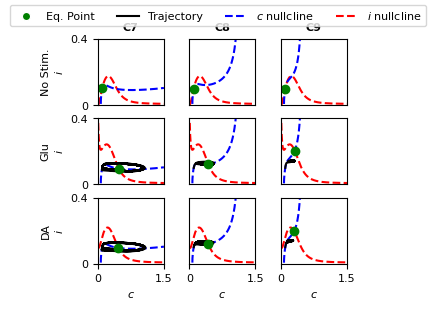

In [21]:
# Graph
fig, ax = plt.subplots(3, 3, figsize = (2.3622*3/2, 1.46*2))
for axis in ax.flatten(): axis.set_box_aspect(1)
plt.subplots_adjust(wspace = 0)


# Model Parameters
model_parameters = define_parameters()
p = create_numba_dictionary(model_parameters)

points = read_from_swc('../../Morphology/Linear_9comparts_corr.txt')
morp_params = calculate_morphological_parameters(points)

glu_list = (0, 5e-5, 0)
da_list = (0, 0, 1e-3)
    
A = morp_params[:,3]
Vol = morp_params[:,5]
r_ER = morp_params[:,6]
Ca_ERalpha_all = np.zeros(n_comparts)
for i_c in range(n_comparts):
    Ca_ERalpha_all[i_c] = bissec_method(null_caer, a = 0, b = 5, tol = 1e-10, p = model_parameters, A = A[i_c], 
                                        Vol = Vol[i_c], r_ER = r_ER[i_c])

    
Ca_imax = [1.5, 1.15, 0.5]

ca_root = [[0.1, 0.1, 0.1],
           [0.4, 0.4, 0.4],
           [0.4, 0.4, 0.4]]

y_label = True
for i_stim in range(3):
    for ic in range(3):
            
        glu = glu_list[i_stim]
        da = da_list[i_stim]

        if ic != 0: 
            y_label = False
            ax[i_stim, ic].set_yticks([])
            ax[i_stim, ic].set_yticklabels([])
        else:
            y_label = True
            ylabel_text = ('No Stim.\n', 'Glu\n', 'DA\n')[i_stim]
            ax[i_stim, ic].set_yticks([0, 0.4])
            ax[i_stim, ic].set_yticklabels([0, 0.4])

        if i_stim != 2:
            ax[i_stim, ic].set_xticks([])
            ax[i_stim, ic].set_xticklabels([])
            x_label = False
        else:
            x_label = True
            ax[i_stim, ic].set_xticks([0, 1.5])
            ax[i_stim, ic].set_xticklabels([0, 1.5])
                        
        A = morp_params[:,3][6+ic]
        Vol = morp_params[:,5][6+ic]
        r_ER = morp_params[:,6][6+ic]
        Ca_ERalpha = Ca_ERalpha_all[6+ic]
        
        if i_stim == 0: 
            ax[i_stim, ic].set_title(f'C{7+ic}', fontsize = 8, weight = 'bold')
            ca = Ca_ctr[ic+1]
            i = IP3_ctr[ic+1]
        elif i_stim == 1:
            ca = Ca_glu[ic+1]
            i = IP3_glu[ic+1]
        elif i_stim == 2:
            ca = Ca_da[ic+1]
            i = IP3_da[ic+1]
        
        graph_phase_space(ax[i_stim, ic], p, A, Vol, r_ER, Ca_ERalpha, Ca_imin = 0.005, Ca_imax = Ca_imax[ic], 
                          plot_trajectory = True, Glu = glu, DA = da, xlabel = x_label, ylabel = y_label, 
                          ylabel_text = ylabel_text, c = ca, i = i, draw_vector = False)

        # Equilibrium points
        func_solv = lambda var: null_point(var, p = p, A = A, Vol = Vol, r_ER = r_ER, 
                                               Glu_o = glu, DA_o = da, Ca_ERalpha = Ca_ERalpha)

        root = fsolve(func_solv, [0.1, ca_root[i_stim][ic]])
        ax[i_stim, ic].plot(root[1], root[0], 'go')

        ax[i_stim, ic].set_ylim(0, 0.4)
        ax[i_stim, ic].set_xlim(0, 1.5)
        ax[i_stim, ic].tick_params(axis = 'both', which = 'both', labelsize = 8)
        
        eigenvalues = linalg.eig(system_jacobian(root[1], root[0], glu, da, p, A, Vol, r_ER, Ca_ERalpha))[0]
        print('Glu: ', glu, ' / DA: ', da, r'$ / \lambda = $', eigenvalues)

        
circle1 = Line2D([0], [0], color = 'white', marker='o', markerfacecolor="green", label='Eq. Point')
line1 = Line2D([0], [0], color = 'k', ls='-', markerfacecolor="black", label='Trajectory')
line2 = Line2D([0], [0], label=r'$c~\mathrm{nullcline}$', color='blue', ls = '--')
line3 = Line2D([0], [0], label=r'$i~\mathrm{nullcline}$', color='red', ls = '--')

#add handles
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([circle1, line1, line2, line3])

#add legend
fig.legend(handles=handles, loc = 'upper center', ncol = 4, fontsize = 8)